# Creating a Skincare Recommender

<img src="images/skincare_cover_photo.jpeg">

Image src: istockphoto.com

## Overview

This project explores skincare products from Sephora in order to build a recommendation system for consumers looking to find different products and develop a skincare routine suited for their needs. Additionally, the recommendations could be used for new users to Sephora who are looking for products based on their skin type and utilizing any past experiences with other skincare products. 

This notebook outlines the implementation of different techniques to build personalized recommendations including iterations to identify a low root-mean-square deviation. From the dataset provided by Anastasia Gorina through [GitHub](.https://github.com/agorina91/final_project/blob/master/Jupyter_Notebook_and_CSV/skindataall.csv), user and product data from specific categories of skincare were examined. 

## Business Understanding

As one of largest cosmetics retailer, Sephora is hoping to find new ways to attract and interact with customers who might find skincare and the number of products out there overwhelming. Specifically, Sephora hopes to take into account past experiences of customers and are hoping to better filter for products to suit their needs.

From both the business and consumer perspectives, it will be beneficial to continually gather/keep track of customer ratings to improve the shopping experience and experiences with using certain products. This will help Sephora understand what customers like and what products may attract more customers. 

## Data Understanding/Preparation

As previously mentioned, I was able to find a dataset via GitHub. Based on their project notes, the data was obtained through webscraping Sephora uses selenium. The two resulting dataframes were combined and cleaned. It contains user and product data joined by unique user ID. Only four skincare categories are present in the dataset, however, there are over 8000 entries. After importing the neccessary libraries and reading in the data, I do some additional cleaning and exploratory analysis. Later on, the dataset will be split to training and testing sets for model validation.

In [1]:
#imports
import numpy as np
import pandas as pd
import random as rn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from os import path
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import GridSearchCV
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

In [2]:
df = pd.read_csv('skindataall.csv', index_col=[0])

In [3]:
df.head()

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,...,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
0,allyp3,Medium,Combination,Brown,Brunette,5,This is hands down the best cleanser I’ve ever...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,3420,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['hand', 'best', 'cleanser', 'ever', 'used', '...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
1,PatTea,Medium,Combination,Brown,Red,1,Unfortunately this doesn’t work for everyone. ...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2483,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['unfortunately', 'work', 'everyone', 'used', ...",0,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
2,Sabi1991,No data,No data,No data,No data,5,My favorite cleanser!! i love the packaging on...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2715,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['favorite', 'cleanser', 'love', 'packaging', ...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
3,happyface2,Fair,Dry,Blue,Blonde,5,I love all things Youth To The People! This cl...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,4497,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['love', 'thing', 'youth', 'people', 'cleanser...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
4,kimkix34,Fair,Normal,Green,Blonde,5,I had a trial size of this and was obsessed. M...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,5017,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['trial', 'size', 'wa', 'obsessed', 'skin', 'f...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8649 entries, 0 to 8702
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Username             8649 non-null   object 
 1   Skin_Tone            8649 non-null   object 
 2   Skin_Type            8649 non-null   object 
 3   Eye_Color            8649 non-null   object 
 4   Hair_Color           8649 non-null   object 
 5   Rating_Stars         8649 non-null   int64  
 6   Review               8649 non-null   object 
 7   Product              8649 non-null   object 
 8   Brand                8649 non-null   object 
 9   Price                8649 non-null   int64  
 10  Rating               8649 non-null   float64
 11  Ingredients          8649 non-null   object 
 12  Combination          8649 non-null   int64  
 13  Dry                  8649 non-null   int64  
 14  Normal               8649 non-null   int64  
 15  Oily                 8649 non-null   i

In [5]:
#checking that all categories of products are what I'm interested in
df['Category'].unique()

array(['Cleanser', 'Moisturizer', 'Face Mask', 'Treatment'], dtype=object)

I'm dropping Username, Eye_Color and Hair_Color columns because I don't believe they are specifically relevant to features that will be used to recommend skin care products within this dataset.

In [3]:
df = df.drop(columns=['Eye_Color', 'Hair_Color'])

The dataset looks fairly clean already, all the labels are relevant to face skincare products with no missing values. I'm going to explore further if there are any repeats and what the distribution of the features are.

In [7]:
#seeing distribution of continuous features
df[['Price', 'Rating_Stars', 'Rating']].describe()

,Price,Rating_Stars,Rating
count,8649.000000,8649.000000,8649.000000
mean,47.289860,4.101861,4.290982
std,35.774619,1.362036,0.470872
min,4.000000,1.000000,0.000000
25%,28.000000,3.000000,4.200000
50%,38.000000,5.000000,4.400000
75%,58.000000,5.000000,4.500000
max,370.000000,5.000000,5.000000


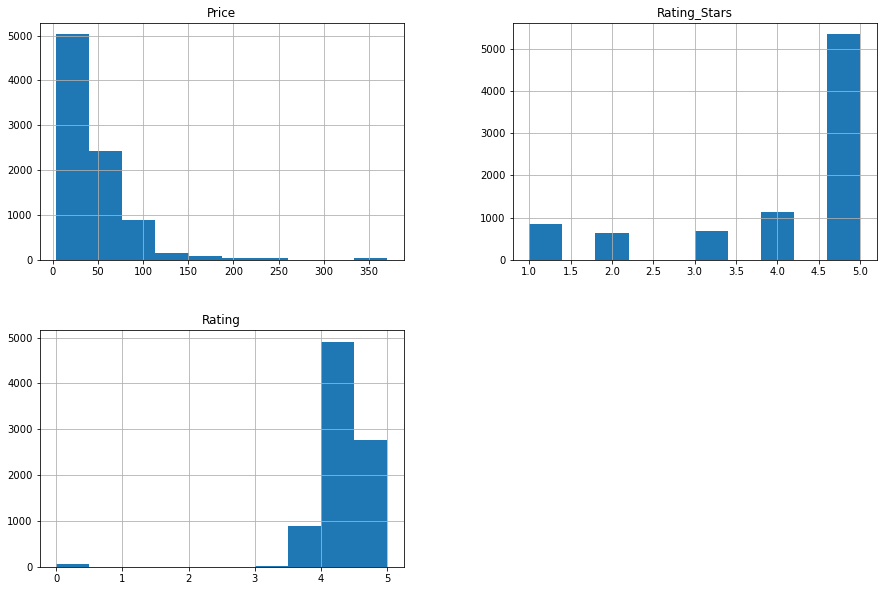

In [8]:
#histograms of continuous features
df[['Price', 'Rating_Stars', 'Rating']].hist(figsize=[15,10]);

It appears that the majority of the products are less than $100, which could be beneficial for consumers looking for more affordable options. For Rating Stars, which is the rating a consumer gives a product on a scale of 1-5 stars shows people usually leaves reviews and ratings when they are satisfied with the product. This also relates to average ratings of products predominately greater than 4.

In [9]:
#how many different brands are there
df['Brand'].describe()

count         8649
unique          60
top       CLINIQUE
freq           685
Name: Brand, dtype: object

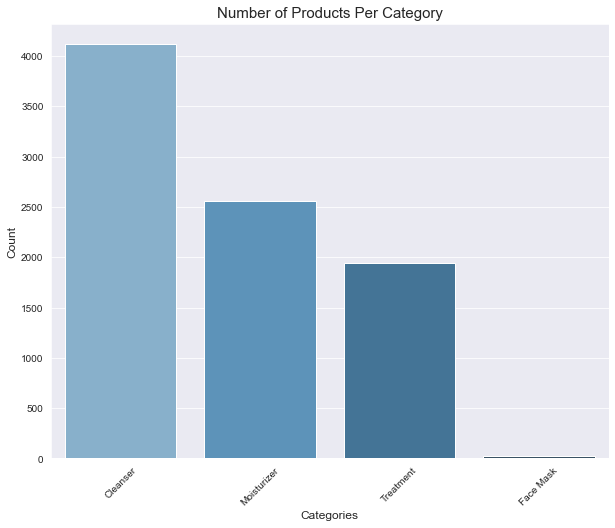

In [10]:
#distribution of different types of products
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Category',
                     palette='Blues_d',
                     order=df.Category.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Categories', size=12)
plt.ylabel('Count', size=12)
plt.title('Number of Products Per Category', size=15)
plt.show()

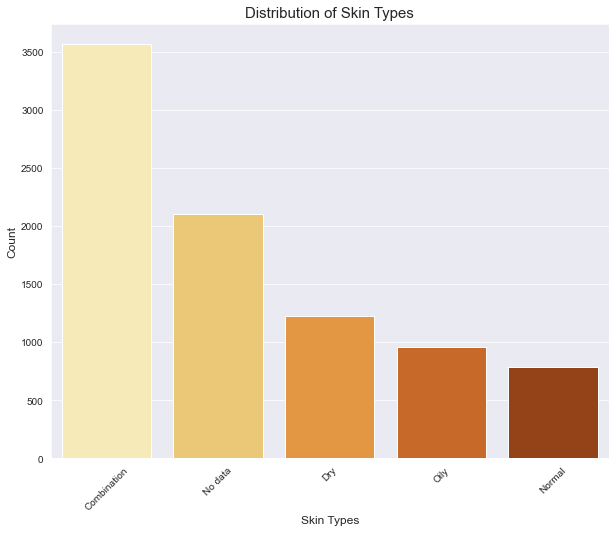

In [11]:
#distribution of skin types
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Skin_Type',
                     palette='YlOrBr',
                     order=df.Skin_Type.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Skin Types', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Skin Types', size=15)
plt.show()

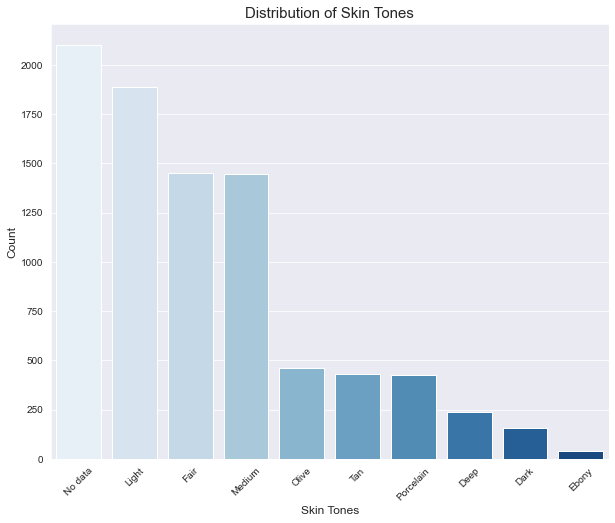

In [4]:
#distribution of skin tone
plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')

plot = sns.countplot(data=df,
                     x='Skin_Tone',
                     palette='Blues',
                     order=df.Skin_Tone.value_counts().index)

plt.setp(plot.get_xticklabels(), rotation=45)
plt.xlabel('Skin Tones', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Skin Tones', size=15)
plt.show()

There is quite a majority of products classified as cleansers within the dataset. By briefly looking over the dataset and with some domain knowledge, I know many products which might be toners or makeup removers can still be used and classified as cleaners. This might be fine for some customers who receive these recommendations, but might not for others. For now, this is a caveat I'll have to keep in mind. Hopefully, in future iterations, we can better filter these products that might fall under multiple categories.

In terms of the distributions of skin types and tones, there are a lot of users that did not specify either. This might make it more difficult to accurately recommend products based on user features, but it is common to have missing data if it's not a required input. Finding recommendations based on multiple different features is probably the best approach.

## Modeling

As mentioned, a recommendation system will help customers find products. There are two main types: unpersonalized and personalized. Currently, on the Sephora landing page, there are carousals of products that "Just Dropped", "Selling Fast", "Chosen For You" (which probably is linked to the specific consumer's account such as purchase and browsing history). For a new customers as well, a more personalized shopping experience can be beneficial. In addition, personalized recommendations based on their needs and any prior experience will be the most applicable.

This is where the different techniques of collaborative filtering comes in. The different approaches will be explored in this modeling section. Through the different models, RMSE is examined to maintain a consistent way of evaluation how well each model performs on the test dataset.

### Collaborative Filtering

#### Memory-Based Approach

KNNBasic vs. KNNMeans vs. KNNBaseline

In [4]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['User_id', 'Product_id', 'Rating_Stars']], reader)
type(data)

surprise.dataset.DatasetAutoFolds

In [5]:
train, test = train_test_split(data, test_size=0.2)

First, I will explore Memory-Based methods of building recommendations. This essentially uses user rating historical data to compute similarity between users or items. This is helpful in recommending the most similar items that haven't been seen/used by the consumer. 

In [6]:
print('Number of users: ', train.n_users, '\n')
print('Number of items: ', train.n_items, '\n')

Number of users:  5712 

Number of items:  315 



In [6]:
dataset = data.build_full_trainset()
print('Number of users: ', dataset.n_users, '\n')
print('Number of items: ', dataset.n_items)

Number of users:  6851 

Number of items:  315


Since there are more users than items in the train set, it makes more sense to calculate item-item similarity rather than between users.

In [8]:
#knn basic w/ cosine
sim_cos = {'name': 'cosine', 'user_based': False}

basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [9]:
predictions = basic.test(test)
print(accuracy.rmse(predictions))

RMSE: 1.2403
1.24025344631553


This model had an RMSE of about 1.25, which means it was roughly 1 point off for each guess in ratings. Although, this is not bad, the scale of ratings for products is only on a scale of 1-5, so a different of about a point or more can be a big difference from someone enjoying the product or not. Potentially utilizing a different similarity metric could improve the model.

In [10]:
#knn basic w/ pearson
sim_pearson = {'name': 'pearson', 'user_based': False}
basic_2 = knns.KNNBasic(sim_options=sim_pearson)
basic_2.fit(train)
predictions = basic_2.test(test)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2195
1.2195205570375094


There was a slight better performance with pearson correlation, so I will use this similarity metric for future models. Next, I will compare the performances of KNN with Means and KNN Baseline.

In [11]:
#knn with means
sim_pearson = {'name': 'pearson', 'user_based': False}
knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
knn_means.fit(train)
predictions = knn_means.test(test)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.2205
1.2205305916847569


In [7]:
#knnbaseline
sim_pearson = {'name': 'pearson', 'user_based': False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(train)
predictions = knn_baseline.test(test)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1909
1.1908948038948888


In [13]:
#cross-validating with KNNBaseline
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [14]:
#print average score for test set
for i in cv_knn_baseline.items():
    print(i)
    
np.mean(cv_knn_baseline['test_rmse'])

('test_rmse', array([1.18797175, 1.23600218, 1.17073827, 1.178374  , 1.19735195]))
('test_mae', array([0.85618702, 0.89029613, 0.86103019, 0.84590487, 0.86774707]))
('fit_time', (0.02579784393310547, 0.019034147262573242, 0.016774892807006836, 0.016193866729736328, 0.016560077667236328))
('test_time', (0.013290166854858398, 0.00935220718383789, 0.00865316390991211, 0.008450746536254883, 0.00997304916381836))


1.1940876341088071

The KNNBaseline method ended up with the lowest RMSE when utilizing pearson correlation. The downside to using memory-based methods is the whole input data is needed and isn't as scale-able when compared to model-based methods.

#### Model-Based Approach

SVD vs. ALS

In [15]:
svd = SVD()
svd.fit(train)

predictions = svd.test(test)
print(accuracy.rmse(predictions))

RMSE: 1.2747
1.2747179599178151


In [16]:
#finding best params for SVD with grid search
params = {
    'n_factors': [10, 50, 100, 200, 500], #number of factors
    'n_epochs': [5, 10, 20, 50, 100], #number of iteration of SGD procedures
    'lr_all': [0.005, 0.01, 0.1], #learning rate for all params
    'reg_all': [0.02, 0.4, 0.6] #regularization term for all params
}

gs_svd = GridSearchCV(SVD, param_grid=params, n_jobs=-1, joblib_verbose=5)
gs_svd.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed:  4.2min finished


In [17]:
print(gs_svd.best_score['rmse'])
print(gs_svd.best_params['rmse'])

1.1864773848696653
{'n_factors': 500, 'n_epochs': 100, 'lr_all': 0.1, 'reg_all': 0.02}


Prior to the gridsearch, the SVD model had an RMSE of about 1.26. After adjusting the parameters, the performance improved slightly with an RMSE 1.19. 

In [28]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName('ALSModel').config('spark.driver.host', 'localhost')\
        .getOrCreate()

In [29]:
py_data = spark.read.csv('skindataall.csv', header='true', inferSchema='true')

In [30]:
py_data = py_data.select('User_id', 'Product_id', 'Rating_Stars')

In [31]:
py_data.dtypes

[('User_id', 'string'), ('Product_id', 'string'), ('Rating_Stars', 'string')]

In [32]:
from pyspark.sql.types import ShortType, ByteType

py_data = py_data.withColumn('User_id', py_data['User_id'].cast(ShortType()))
py_data = py_data.withColumn('Product_id', py_data['Product_id'].cast(ShortType()))
py_data = py_data.withColumn('Rating_Stars', py_data['Rating_Stars'].cast(ByteType()))

In [33]:
py_data.dtypes

[('User_id', 'smallint'),
 ('Product_id', 'smallint'),
 ('Rating_Stars', 'tinyint')]

In [36]:
py_data.filter("User_id is NULL").show()

+-------+----------+------------+
|User_id|Product_id|Rating_Stars|
+-------+----------+------------+
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           1|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           3|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           1|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
|   null|      null|           5|
|   null|      null|           0|
+-------+----------+------------+
only showing top 20 rows



In [37]:
py_data = py_data.na.fill(value=0)

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

(train, test) = py_data.randomSplit([0.8, 0.2])

In [40]:
als = ALS(maxIter=5,
          rank=4,
          regParam=0.01,
          userCol='User_id',
          itemCol='Product_id',
          ratingCol='Rating_Stars',
          coldStartStrategy='drop')

als_model = als.fit(train)

In [41]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = als_model.transform(test)
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='Rating_Stars',
                                predictionCol='prediction')

rmse = evaluator.evaluate(predictions)
print('RMSE: ' + str(rmse))

RMSE: 2.378393745752967


In [51]:
#cross validate to find best params for ALS 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

als_model2 = ALS(userCol='User_id',
                itemCol='Product_id',
                ratingCol='Rating_Stars',
                coldStartStrategy='drop')

params = ParamGridBuilder()\
            .addGrid(als_model2.regParam, [0.01, 0.001, 0.1])\
            .addGrid(als_model2.rank, [4, 10, 50]).build()

cv = CrossValidator(estimator=als_model2, 
                    estimatorParamMaps=params, 
                    evaluator=evaluator, 
                    parallelism=4)

best_als = cv.fit(py_data)
best_als.bestModel.rank

50

In [56]:
als_cv = ALS(maxIter=5,
             rank=50,
             regParam=0.01,
             userCol='User_id',
             itemCol='Product_id',
             ratingCol='Rating_Stars',
             coldStartStrategy='drop')

als_model2 = als_cv.fit(train)

predictions = als_model2.transform(test)
evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='Rating_Stars',
                                predictionCol='prediction')

rmse = evaluator.evaluate(predictions)
print('RMSE: ' + str(rmse))

RMSE: 2.120258332537024


After tuning ALS slightly, RMSE only approved slightly as well and still about 1 point worse than the Knn Baseline and SVD.

### Recommender Based on Customer Features

To start, it is quite straightforward to filter the products and recommend top-rated products based on an input of features such as the customer's skin type and what type of product they are looking for. This can then be built upon to include other features that customers might like to consider such as price.

In [51]:
def rec_by_user_needs(skin_type, cat_type, percentile=0.9):
    ddf = df[(df['Skin_Type']==skin_type) & (df['Category'] ==cat_type)]
    
    recs = ddf[['Rating', 'Product', 'Brand', 'Price', 'Product_Url']]
    recs = recs.sort_values('Rating', ascending=False).drop_duplicates().head()
    
    print('Here are your top 5 recommendations:')
    return recs

In [54]:
rec_by_user_needs('Dry', 'Cleanser')

Here are your top 5 recommendations:


,Rating,Product,Brand,Price,Product_Url
4786,5.0,Epidermal Re-Texturizing Micro-Dermabrasion,KIEHL'S SINCE 1851,41,https://www.sephora.com/product/epidermal-re-t...
6015,4.9,Multi-Miracle Glow Cleansing Balm,CHARLOTTE TILBURY,60,https://www.sephora.com/product/multi-miracle-...
600,4.9,Facial Cotton,SHISEIDO,10,https://www.sephora.com/product/facial-cotton-...
6392,4.9,Fresh Pressed Renewing Powder Cleanser with Pu...,CLINIQUE,29,https://www.sephora.com/product/fresh-pressed-...
5264,4.9,Exfoilating Wipes - Papaya - Glow,SEPHORA COLLECTION,7,https://www.sephora.com/product/exfoilating-wi...


To build off of this, we can use our models to further predict and make recommendations that are more specifically tailored to customer preferences. 

In [9]:
#simple predictions with KNNBaseline
knn_baseline.fit(dataset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [10]:
knn_baseline.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.8179128371211366, details={'actual_k': 0, 'was_impossible': False})

It's nice to make simple predictions based on this model; however, it would be more beneficial to get specific products based on the customer's preferences. This function will obtain customer ratings from randomly selected products, take into account these preferences and give a list of products that is also based on the specific category and skin type that customers indicate.

In [68]:
def skincare_rec(num, product_df, category=None, skin_type=None):
    raw_userid = input('Enter ID: ')
    rating_list = []
    #filter df based on skin type/category and get new ratings
    while num > 0:
        if skin_type:
            product_df = product_df[product_df[skin_type] == 1]
        else:
            product_df = product_df
        if category:
            product_df = product_df[product_df['Category'] == category]
            product = product_df.sample(1)
        else:
            product = product_df.sample(1)
        print(product[['Product', 'Brand', 'Price', 'Product_Url']])
        rating = input(
            'How do you rate this product on a scale of 1-5, press n if you have not used this before:\n'
        )
        if rating == 'n':
            continue
        else:
            rating_one_product = {
                'User_id': raw_userid,
                'Product_id': product['Product_id'].values[0],
                'Rating_Stars': rating
            }
            rating_list.append(rating_one_product)
            num -= 1

    #add the new ratings to the original df
    new_ratings_df = product_df[['User_id', 'Product_id',
                                 'Rating_Stars']].append(rating_list,
                                                         ignore_index=True)
    new_data = Dataset.load_from_df(new_ratings_df, reader)
    #train model on the new combined df
    knn_baseline = knns.KNNBaseline(sim_options={
        'name': 'pearson',
        'user_based': False
    })
    knn_baseline.fit(new_data.build_full_trainset())
    #make predictions for the customer; order the predictions from high to low
    list_of_prods = []
    for prod_id in product_df['Product_id'].unique():
        list_of_prods.append(
            (prod_id, knn_baseline.predict(raw_userid, prod_id)[3]))
    ranked_prods = sorted(list_of_prods, key=lambda x: x[1], reverse=True)
    #return the top n recommendations
    num_prods = int(
        input('How many products would you like to be recommended to you?\n'))
    for idx, rec in enumerate(ranked_prods):
        name = product_df.loc[product_df['Product_id'] == int(
            rec[0])]['Product']
        print('Recommendation #', idx + 1, ': ', name.drop_duplicates(), '\n')
        num_prods -= 1
        if num_prods == 0:
            break

In [62]:
skincare_rec(2, df, 'Moisturizer', 'Oily')

Enter ID: 999
                                  Product      Brand  Price  \
1900  Pink Cloud Rosewater Moisture Crème  HERBIVORE     48   

                                            Product_Url  
1900  https://www.sephora.com/product/pink-cloud-ros...  
How do you rate this product on a scale of 1-5, press n if you have not used this before:
3
                           Product  Brand  Price  \
7795  GenOptics Aura Essence Serum  SK-II    240   

                                            Product_Url  
7795  https://www.sephora.com/product/genoptics-aura...  
How do you rate this product on a scale of 1-5, press n if you have not used this before:
5
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
How many products would you like to be recommended to you?
3
Recommendation # 1 :  7772    GenOptics Aura Essence Serum
Name: Product, dtype: object 

Recommendation # 2 :  3000    Vine[activ] Overnight Detox Oil
Name: Product, dt

In [69]:
skincare_rec(3, df)

Enter ID: 777
           Product     Brand  Price  \
471  Beauty Elixir  CAUDALIE     18   

                                           Product_Url  
471  https://www.sephora.com/product/beauty-elixir-...  
How do you rate this product on a scale of 1-5, press n if you have not used this before:
4
                                    Product  Brand  Price  \
6604  R.N.A. POWER Anti-Aging Essence Serum  SK-II    195   

                                            Product_Url  
6604  https://www.sephora.com/product/r-n-a-power-ra...  
How do you rate this product on a scale of 1-5, press n if you have not used this before:
4
                                                Product     Brand  Price  \
4702  Blackhead Solutions 7 Day Deep Pore Cleanse & ...  CLINIQUE     24   

                                            Product_Url  
4702  https://www.sephora.com/product/blackhead-solu...  
How do you rate this product on a scale of 1-5, press n if you have not used this before:
4
Estimatin

As seen above, customers are able to put in their skin type and further filter products or just go through random products. Then upon rating products that they may have used in the past, the similarity matrix is calculated to find the desired number of recommended products most similar to the inputs.

## Evaluation

I was able to successfully implement collaborative filtering models, between memory-based and model-based approaches, the KNN Baseline and SVD were the best performing in terms of low RMSE scores. Between these two approaches, I ultimately decided to use ____ since ____.

Upon iterating through the models, I incorporated the model with the parameters to retrieve recommendations for a customer by adding new ratings and then giving a specified number of recommendations. 

This is able to not only recommend products, it is a tool that can help Sephora attract customers and especially new customers who want to be suggested specific products rather than spending time clicking through pages of products. This can be overwhelming and with a recommender, the online shopping experience can feel a bit more personal.

From this initial analysis, I was able to explore a portion of recommendation systems that can be beneficial for businesses and help gather data that can be useful to know. It is important to recognize that recommendation systems are very dependent on the use case or in other words, the needs of the business and what type of information do we want to provide to users. 

### Next Steps

Through this iterative process, a few things to be considered for future exploration:

- Obtaining more data on different products and users will allow the recommendation system to be scaled and become more sophisticated. Not only would there be more data to analyze, more products and different types of products could be recommended to customers.
- It would be interesting to explore different ways to recommend products such as looking at ingredients and recommending products based on other products that customers like.
